# RandomForestRegressor Con series Temporales
### (TimeSeriesSplit)

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://raw.githubusercontent.com/albercol/TFG/main/Fase2/Fase%202.3/DatosUnificados/Cont_Meteo_Traf.csv"
df = pd.read_csv(url,parse_dates=['FECHAH'])
df = df.dropna()

#Transformamos la columna tipo en 3 columnas numericas para cada tipo (LABORABLE, SABADO, DOMINGO, FESTIVO)
valores = df.TIPO.unique()
for v in valores:
    print(v)
    df[v] = df.TIPO.apply(lambda x: 1 if x==v else 0)

#Borramos las columnas que no son necesarias.
df = df.drop(['TIPO', 'NO', 'PM10', 'NOx'], axis=1)
df=df.set_index(['FECHAH'])
df.dropna(inplace=True)
df

LABORABLE
SABADO
DOMINGO
FESTIVO


,CO,NO2,PM2.5,O3,VELOCIDAD VIENTO,DIR. VIENTO,TEMPERATURA,HUMEDAD RELATIVA,PRESION BAROMETRICA,PRECIPITACIONES,ES10,ES53,ESSUMA,LABORABLE,SABADO,DOMINGO,FESTIVO
FECHAH,,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,0.2,22.0,10.0,58.87,1.84,97.0,26.1,52.0,943.0,0.0,223.0,347.0,570.0,1,0,0,0
2019-08-01 01:00:00,0.2,15.0,10.0,63.73,1.97,117.0,24.9,55.0,943.0,0.0,173.0,231.0,404.0,1,0,0,0
2019-08-01 02:00:00,0.1,14.0,9.0,66.50,1.72,96.0,24.0,55.0,943.0,0.0,107.0,180.0,287.0,1,0,0,0
2019-08-01 03:00:00,0.1,14.0,10.0,66.62,1.55,106.0,23.3,55.0,943.0,0.0,80.0,129.0,209.0,1,0,0,0
2019-08-01 04:00:00,0.2,15.0,10.0,62.57,1.13,67.0,22.9,57.0,943.0,0.0,89.0,105.0,194.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25 10:00:00,0.3,38.0,9.0,47.20,1.37,79.0,18.3,46.0,953.0,0.0,587.0,658.0,1245.0,1,0,0,0
2021-05-25 11:00:00,0.3,37.0,7.0,60.22,1.93,62.0,19.3,42.0,953.0,0.0,582.0,651.0,1233.0,1,0,0,0
2021-05-25 12:00:00,0.2,31.0,7.0,73.93,1.53,12.0,21.2,38.0,952.0,0.0,573.0,743.0,1316.0,1,0,0,0


In [112]:
def pintarGrafico(y_pred, y_test, nombre, mae):
    cuantos = 8
    ypred = y_pred[:cuantos]
    ylabel = list(y_test)[:cuantos]
    x = list(range(len(ylabel)))
    plt.rcParams["font.size"] = 10
    figure, ax = plt.subplots(1,figsize=(4, 4),dpi=100)    
    for i in range(len(x)):
        plt.plot([x[i],x[i]],[ypred[i],ylabel[i]],color="darkorange")

    plt.title("Prediccion para " + nombre + " mae: " + str(round(mae, 3)))
    plt.scatter(x,ypred, color='blue', label="pred",s=8)
    plt.scatter(x,ylabel, color='green', label="label",s=4)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [117]:
"""
Extend: agrega elementos de una estructura iterable, por ejemplo, si enviamos un objeto puro, 
no sabe cómo agregarlo, sin embargo, si enviamos ese mismo objeto dentro de una lista, escaneará la 
lista y agregará ese objeto y, si hay otros, el resto dentro de la lista.
"""

def split_test(df,  predict, hAnterior):
    #asignamoes una variable al modelo y seleccionamos el mejor mae.
    model_chos, mae_ctrl = None, 5000
    
    colsX = [ 'VELOCIDAD VIENTO', 'DIR. VIENTO', 'TEMPERATURA', 'HUMEDAD RELATIVA',
           'PRESION BAROMETRICA', 'PRECIPITACIONES', 'ES10','ES53',"LABORABLE",
             "SABADO","DOMINGO", "FESTIVO"]
     
    #Se le añade el valor predicho del la hora anterior.
    if hAnterior:
        colsX.append("pred")
        #Añadimos la columna con la prediccion de la hora anterior
        df["pred"] = df[predict].shift(+1)
        df = df[1:]
        
    X = df[colsX].values
    y = df[predict].values

    n_splits = 5
    splits = TimeSeriesSplit(n_splits=n_splits)
    model = RandomForestRegressor()
    print(splits)
    
    for step, (train_index, test_index) in enumerate(splits.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if len(predict) == 1: 
            y_train = y_train.ravel()
            
        #entrenamos el modelo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_pred,y_test)
        
        if mae_ctrl > mae: 
            print(f'Step {step}')
            print(f'Observations: {len(X_train) + len(X_test)}')
            print(f'Training Observations: {len(X_train)}')
            print(f'Testing Observations: {len(X_test)}')
            print("MAE: ", mae)
            print(".-.-.-.-.-.-.")
            model_chos = model
            mae_ctrl = mae
        
    return model_chos, mae_ctrl

#predict = ['CO', 'NO2', 'PM2.5', 'O3']
predict = ['NO2']
df2 = df
modelRf, mae = split_test(df2, predict, True)

print("El mejor MAE: ", mae)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Step 0
Observations: 4904
Training Observations: 2454
Testing Observations: 2450
MAE:  7.182379591836735
.-.-.-.-.-.-.
Step 1
Observations: 7354
Training Observations: 4904
Testing Observations: 2450
MAE:  5.72950612244898
.-.-.-.-.-.-.
El mejor MAE:  5.72950612244898


In [118]:
# Añadir el campo fecha y decir, quiero la precicion de dentro de n dias desde la fecha 01/01/2021 00:00:01
def pred(ndays, model, df):
    df_pred = pd.DataFrame(columns = ["CO", "NO2","PM2.5", "O3"])
    # Conseguir todos los datos de entrada para la fecha dada del dataset  -> [[570.0, 943.0, 28.0, 52.0, 97.0, 223.0, 1.84, 2, 347.0, 26.1, 0.0]]
    filas = df.values
    print(filas[0][0])
    prev_N02 = filas[0][9]
    for i in range(ndays):
        ini = [[filas[i][0], filas[i][1], filas[i][2], filas[i][3], filas[i][4], filas[i][5], filas[i][6], filas[i][7], filas[i][8], prev_N02, filas[i][10], filas[i][11], filas[i][12], filas[i][13]]]
        c0, prev_N02, pm, o3 = model.predict(ini).flatten()
        print(f"Predichos -> Hour {i+1}, CO: {c0}, NO2: {prev_N02}, PM: {pm}, O3: {o3}")
        df_pred.loc[i]=[ c0, prev_N02, pm, o3 ]
    return df_pred

In [119]:
filtered_df=df.loc['2021-05-25 0:00:00':'2021-05-25 10:00:00']
filtered_df = filtered_df.drop(["CO","NO2","PM2.5","O3"], axis=1)
filtered_df

,VELOCIDAD VIENTO,DIR. VIENTO,TEMPERATURA,HUMEDAD RELATIVA,PRESION BAROMETRICA,PRECIPITACIONES,ES10,ES53,ESSUMA,LABORABLE,SABADO,DOMINGO,FESTIVO,pred
FECHAH,,,,,,,,,,,,,,
2021-05-25 00:00:00,0.89,300.0,17.8,44.0,951.0,0.0,159.0,285.0,444.0,1,0,0,0,24.0
2021-05-25 01:00:00,0.57,226.0,16.6,45.0,951.0,0.0,64.0,205.0,269.0,1,0,0,0,16.0
2021-05-25 02:00:00,0.68,257.0,16.1,41.0,951.0,0.0,88.0,137.0,225.0,1,0,0,0,19.0
2021-05-25 03:00:00,0.62,8.0,15.4,44.0,951.0,0.0,61.0,112.0,173.0,1,0,0,0,10.0
2021-05-25 04:00:00,0.57,61.0,13.9,51.0,951.0,0.0,63.0,97.0,160.0,1,0,0,0,15.0
2021-05-25 05:00:00,0.79,57.0,14.2,54.0,951.0,0.0,167.0,114.0,281.0,1,0,0,0,23.0
2021-05-25 06:00:00,0.85,43.0,13.1,62.0,952.0,0.0,429.0,328.0,757.0,1,0,0,0,18.0
2021-05-25 07:00:00,1.24,55.0,12.8,63.0,953.0,0.0,711.0,627.0,1338.0,1,0,0,0,31.0
2021-05-25 08:00:00,1.45,69.0,13.8,59.0,953.0,0.0,695.0,693.0,1388.0,1,0,0,0,51.0


In [120]:
# time delta de la fecha que da el usuario + 8 horas ej, y comparas   
df_pred = pred(8, modelRf, filtered_df)

0.89


ValueError: X has 14 features, but DecisionTreeRegressor is expecting 13 features as input.

In [105]:
df_pred
df_test=df.loc['2021-05-25 0:00:00':'2021-05-25 10:00:00']

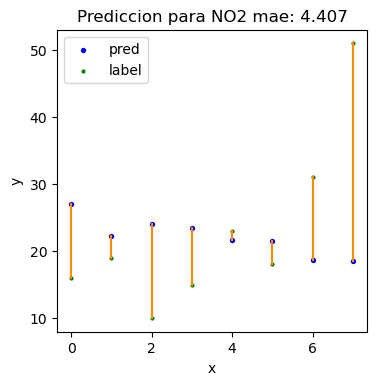

In [106]:
pintarGrafico(df_pred["NO2"], df_test["NO2"], "NO2", mae)

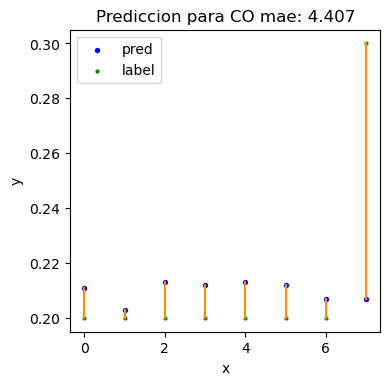

In [107]:
pintarGrafico(df_pred["CO"], df_test["CO"], "CO", mae)